In [1]:
import xarray as xr
import valenspy as vp
from datatree import DataTree
from pathlib import Path
import pandas as pd
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import os

#Get the git directory using the Path object using an os command
git_dir = Path(os.popen("git rev-parse --show-toplevel").read().strip())


#User options
variables = ["tas", "pr"]
period = [1980,1981] # [1980,2019]
target_grid="/dodrio/scratch/projects/2022_200/external/climate_grid/TEMP_AVG_CLIMATE_GRID_1954_2023_daily.nc"

############################################
# STEP 1: Loading the data

# start input manager
manager = vp.InputManager(machine="hortense")


#MODEL data
# Load the ALARO data
df_alaro = pd.read_csv("/dodrio/scratch/users/vsc31332/rmi/vsc31332_inne/ValEnsPy/CORDEX_eval_scripts/catalog.csv")
df_alaro = df_alaro[df_alaro['frequency'] == 'day']
df_alaro = df_alaro[df_alaro['variable_id'].isin(variables)]
df_alaro

#Load all the paths in the df into one xarray dataset
ds_alaro = xr.open_mfdataset(df_alaro['path'].values, decode_coords='all', chunks="auto")
ds_alaro

# Load the COSMO data
## Issue - variarble names are hardcoded due to daily statistic, necessary to find correct path with input manager
experiment = "CB2_CCLM_EUR11_ERA5_evaluation"
ds_cclm_tas = manager.load_data("CCLM", ["tas"], freq="daily", path_identifiers=[experiment, "mean"])
ds_cclm_pr  = manager.load_data("CCLM", ["pr"], freq="daily", path_identifiers=[experiment, "sum"])
ds_cclm = xr.merge([ds_cclm_tas, ds_cclm_pr])
del ds_cclm_tas, ds_cclm_pr


# Load the MAR data
## palceholder for MAR data -for plotting purposes
ds_mar = ds_alaro

#OBSERVATIONAL data

# Load CLIMATE_GRID
## Issue - currently can't load the ungridded CLIMATE_GRID data as there is no unique identifier for the data 

ds_ref = manager.load_data("CLIMATE_GRID", variables, path_identifiers=["regridded"])

# Create a DataTree object
data_dict = {
    "RCM/ERA5/ALARO1_SFX": ds_alaro,
    "RCM/ERA5/CCLM6-0-1-URB-ESG": ds_cclm,
    "RCM/ERA5/MAR": ds_mar,
    "obs/CLIMATE_GRID": ds_ref
}

dt = DataTree.from_dict(data_dict)

############################################
# STEP 2: Preprocessing the data

## Regrid (currently to CLIMATE_GRID)
dt["RCM"] = dt["RCM"].map_over_subtree(vp.remap_xesmf, dt.obs.CLIMATE_GRID.to_dataset(), method="bilinear", regridding_kwargs={"keep_attrs": True})

## Select the time period from 1980 to 2002 (inclusive)
dt = dt.sel(time=slice(f"{period[0]}-01-01", f"{period[1]}-12-31"))


############################################
# STEP 3: Diagnostics

/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python3.10/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


File paths found:
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_2012.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_1986.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_1982.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_1987.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_1991.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_1993.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/dail

In [2]:

dt = DataTree.from_dict(data_dict)

############################################
# STEP 2: Preprocessing the data

## Regrid (currently to CLIMATE_GRID)
dt["RCM"] = dt["RCM"].map_over_subtree(vp.remap_xesmf, dt.obs.CLIMATE_GRID.to_dataset(), method="bilinear", regridding_kwargs={"keep_attrs": True})

## Select the time period from 1980 to 2002 (inclusive)
dt = dt.sel(time=slice(f"{period[0]}-01-01", f"{period[1]}-12-31"))

In [3]:
import numpy as np
import cartopy.crs as ccrs

from valenspy.diagnostic.visualizations import _add_features
from valenspy._utilities.unit_conversion_functions import convert_kg_m2s_to_mm_day

In [4]:
# STEP 3: Diagnostics

## Calculate time average

# settings
averaging_period = 'annual'


# based on averaging_period, do subset of the time period selected 

def select_months_djf(dt):
    return ds.sel(time=ds['time.month'].isin([12, 1, 2]))
def select_months_jja(dt):
    return ds.sel(time=ds['time.month'].isin([6, 7, 8]))

if averaging_period == 'annual':
    dt = dt
elif averaging_period == "DJF": 
    dt = dt.map_over_subtree(select_months_dfj)
elif averaging_period == "JJA": 
    dt = dt.map_over_subtree(select_months_jja)


# calculate time mean for every dataset in tree
def mean_over_time(ds):
    return ds.mean(dim='time')

dt_timmean = dt.map_over_subtree(mean_over_time)

# convert precipitation units from kg m-2 s-1 to mm day-1
# Does not work yet!!! 
"""
def convert_kg_m2s_to_mm_day_ds(ds):
    ds['pr'] = convert_kg_m2s_to_mm_day(ds['pr'])
    ds['pr'].attrs["units"] = "mm day-1"
    return ds

dt_timmean = dt_timmean.map_over_subtree(convert_kg_m2s_to_mm_day)
"""


#Compute the data once (not for every diagnostic separately)
with ProgressBar():
    dt_timmean = dt_timmean.compute()

[########################################] | 100% Completed | 12.42 s
[########################################] | 100% Completed | 4.29 sms
[########################################] | 100% Completed | 6.76 sms
[########################################] | 100% Completed | 4.51 sms


In [5]:
# calculate min and max values for colorbar
def get_dt_overall_min_max(dt, variable):
    
    mins = []
    maxs = []

    for ds in dt.leaves: 
        mins.append(ds[variable].min(dim=('lat','lon')).values)
        maxs.append(ds[variable].max(dim=('lat','lon')).values)
    overall_min = min(np.array(mins))
    overall_max = max(np.array(maxs))

    return overall_min, overall_max


In [6]:
def set_plot_param():
    """Set my own customized plotting parameters"""
    
    import matplotlib as mpl
    mpl.rc('axes',edgecolor='grey')
    mpl.rc('axes',labelcolor='dimgrey')
    mpl.rc('xtick',color='dimgrey')
    mpl.rc('xtick',labelsize=10)
    mpl.rc('ytick',color='dimgrey')
    mpl.rc('ytick',labelsize=10)
    mpl.rc('axes',titlesize=14)
    mpl.rc('axes',labelsize=10)
    mpl.rc('legend',fontsize='large')
    mpl.rc('text',color='dimgrey')

set_plot_param()

/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/rcs/software/miniconda3/envs/valenspy_xesmf/lib/python

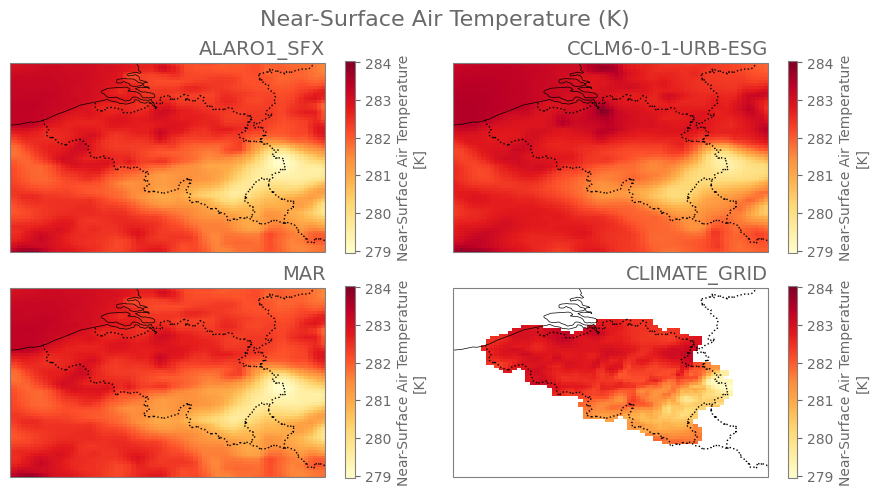

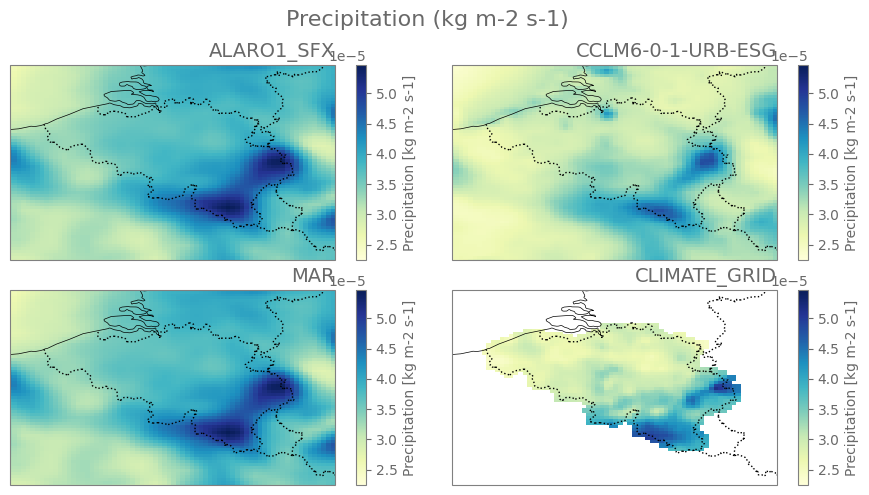

In [7]:
# define colormaps per variable
d_cmap = {
    "tas": 'YlOrRd',
    "pr": 'YlGnBu' }

## Plot maps absolute values
for variable in variables: 

    # create figure 
    fig, axes = plt.subplots(2,2,figsize=(9,5), subplot_kw={"projection": ccrs.PlateCarree()})
    axes = axes.flatten()

    # get overall min and max
    overall_min, overall_max = get_dt_overall_min_max(dt_timmean, variable)

    # loop over datasets to do plotting
    for i, dt_leave in enumerate(dt_timmean.leaves):
        ax = axes[i]
        ds = dt_leave.to_dataset()
        ds[variable].plot(ax=ax, cmap=d_cmap[variable], vmin=overall_min, vmax=overall_max)
        ax.set_title(dt_leave.name, loc='right')
        ax.set_title(' ')
        _add_features(ax, region='belgium')

    fig.suptitle(f'{ds[variable].long_name} ({ds[variable].units})', fontsize=16)

    fig.tight_layout()
    # Mean maps
    plt.savefig(f"/dodrio/scratch/users/vsc31332/rmi/vsc31332_inne/ValEnsPy/CORDEX_eval_scripts/plots/timmean_{variable}_{averaging_period}.png")

### Mean spatial bias

In [8]:
# Calculate spatial bias
## Spatial Bias
from valenspy.diagnostic import SpatialBias

# climate grid as reference
ds_ref =  dt["obs/CLIMATE_GRID"].to_dataset()
with ProgressBar():
    dt_spatialbias = dt_timmean.RCM.map_over_subtree(SpatialBias, ds_ref)


ValueError: cbar_ax and cbar_kwargs can't be used with add_colorbar=False.

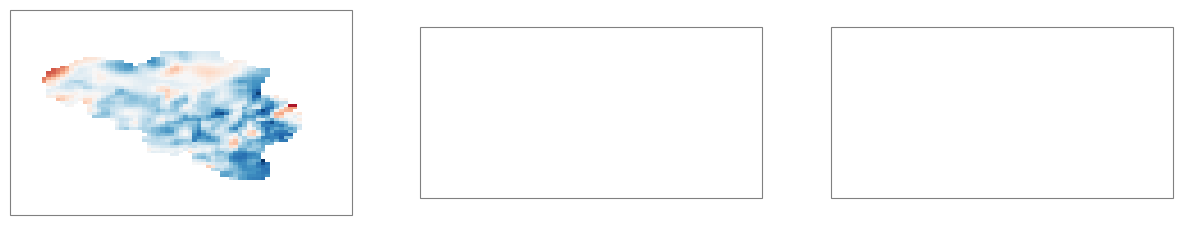

In [9]:
# define colormaps per variable
d_cmap_bias = { "tas": 'RdBu_r', "pr": 'BrBG' }


for variable in variables: 

    # plotting 
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={"projection": ccrs.PlateCarree()})
    axes = axes.flatten()

    # get overall min and max
    overall_min, overall_max = get_dt_overall_min_max(dt_spatialbias, variable)

    for i, dt_leave in enumerate(dt_spatialbias.leaves):
        ax = axes[i]
        ds_spbias = dt_leave.to_dataset()

        # add colorbar only for last plot
        add_colorbar = (i == len(dt_spatialbias.leaves) - 1)

        cbar_kwargs={"aspect": 30 }

        SpatialBias.plot(ds_spbias[variable], ax=ax, cmap=d_cmap_bias[variable], add_colorbar=add_colorbar, cbar_kwargs = cbar_kwargs )
     
        ax.set_title(dt_leave.name, loc='right')
        ax.set_title(' ')
        _add_features(ax, region='belgium')


    fig.suptitle(f'{ds[variable].long_name} bias compared to CLIMATE_GRID ({averaging_period})', fontsize=16)
    fig.tight_layout()

    plt.savefig(f"/dodrio/scratch/users/vsc31332/rmi/vsc31332_inne/ValEnsPy/CORDEX_eval_scripts/plots/spatialbias_{variable}_{averaging_period}.png")

### Scores

### Rx1day